# Exploring causal models of mental health   
***
Richard Morris 16 May, 2018  
## Introduction  
*** 
Answering causal questions in the social sciences (e.g., economics, public health) is difficult due to the inability to intervene in the causal variable and measure the impact of the intervention. However with the growing availability of large observational datasets and advances in statistical methods, other approaches to exploring causal questions are increasingly possible. Here we explore the application of a Bayesian network to answer a causal question in the Household Income and Labour Dynamics in Australia (HILDA) survey.  
  
Bayesian networks are a Graphical model which represent the joint probability distribution between the variables of interest. Graphical models represent variables of interest as *nodes* and the associations between them as *arcs* or *edges*. In a Bayesian network, the edges represent the conditional probability of a node given it's parent. That is, a node may be a child of an upstream variable and a parent of a downstream variable. In a Bayesian network, a node may be conditionally dependent on a number of parent nodes, and also be associated with a number of child nodes. From an intuitive point of view, it can be argued that a “good” Bayesian network should represent the causal structure of the data it is describing. Such networks are usually fairly sparse, and their interpretation is at the same time clear and meaningful (Pearl, 2009). However, learning causal models, especially from observational data, presents significant challenges. Three additional assumptions are needed compared to non-causal Bayesian network learning:
- There must exist a network structure that is faithful to the dependence structure of the causal system
- There must be no latent variables (unobserved variables in the network) acting as confounding factors
- Each variable is conditionally independent of its non-effects given its direct causes (this is the Causal Markov Assumption)  
  
It is worth noting that even when dealing with interventional data (a true experiment), these assumptions may not be met. For instance, there are usually multiple equivalent network structures that could explain the data resulting from a true experiment (e.g., a latent variable could be mediating the effect of the intervention observed or a confound may exist). However one way to ensure the third assumption is met (Causal Markov Assumption) in observational data is to incorporate a unidirectional effect of time in the model. This obviously requires a dataset that is collected over multiple timepoints, and the unidirectional effect of time ensures that associations between variables at $t_2$ cannot influence variables at $t_1$. One such dataset is provided by the [HILDA survey](https://melbourneinstitute.unimelb.edu.au/hilda), which has collected responses from more than 17,000 Australians over 16 years.  
  
The HILDA survey provides a relatively comprehensive assessment of labour force participation, income, family characteristics, as well as personal life events, health and satisfaction. Included in this is the SF-36 health survey, which in turn provides a mental health score derived from agreement with five statements:
 
> How much of the time during the past 4 weeks have you :
> 1. Been a nervous person
> 2. Felt so down in the dumps nothing could cheer you up
> 3. Felt calm and peaceful
> 4. Felt down
> 5. Been a happy person

  
This dataset allows us to ask what variables may influence mental health, and *vice versa*, in the Australian population. Here we apply a dynamic Bayesian network analysis to test different causal networks around mental health. 
  
## Experiment 1
***
There are a variety of variables in the HILDA survey that we could include in our causal model. Initially we will focus on nine variables that represent indicators of **happiness, health, finance, social support, personal control, and relationship satisfaction**. These variables have been selected to represent each category while minimising selection bias as much as possible (e.g., none of the variables depend upon employment or relationship status)  

1. 'ghmh', MH-I5
2. 'losat', life satisfaction
3. 'losatyh', health satisfaction
4. 'wscei', weekly gross wages/salary
5. 'lssupac', I don't have anyone I can confide in
6. 'lssupvl', I often feel very lonely
7. 'lsrush', feeling rushed
8. 'lshrhw', hours per week housework
9. 'lsshare', share of housework
  
In this experiment we will use the ARTIVA package (in R) to estimate the causal structure that may exist between the variables.  
  
### Methods
***
In Experiment 1 we will determine the causal network between nine variables, among the 3206 people with a complete set of variable scores in each wave. However due to computational limitations, we will randomly sample ***n* = 1000** from the total sample. In this way, a unique set of n = 1000 can be obtained up to three times to repeat the experiment and thus test the **replicability** of the obtained causal network. 

In [3]:
#### Set up some working directories ####
setwd("~/Dropbox/HILDA/Causal-models")
datadir <- ("~/Dropbox/HILDA/data/")

#### load some libraries ####
library(tidyverse)
library(haven)
library(ARTIVA)
source("~/Dropbox/HILDA/src/JoinFrames.R")
source("~/Dropbox/HILDA/src/GetVarsLong.R")
source("~/Dropbox/HILDA/src/ZapLabel.R")

In [ ]:
#### NOT RUN: Time to complete > 6 days ####

#### Load the HILDA dataset ####
filepaths <- list.files(
  path = datadir,
  pattern = '^Combined.*.dta$',
  full.names = TRUE
)

cat('Importing dataframes')
hildadata <- list()
for (pathtofile in filepaths) {
  df <- read_dta(pathtofile)
  hildadata <- append(hildadata, list(df))
  cat('.')
}
cat('Done')

#### Create the variable matrices ####
predictors <- c('ghmh',       # mental health
                'losat',      # life satisfaction
                'losatyh',    # health satisfaction
                'wscei',      # weekly gross wages/salary
                'lssupac',    # I don't have anyone I can confide in
                'lssupvl',    # I often feel very lonely
                'lsrush',     # feeling rushed
                'lshrhw',     # hours per week housework
                'lsshare'     # share of housework
                )

df.long <- GetVarsLong(hildadata, predictors)
respondants <- unique(df.long$xwaveid)
df.sample <- filter(df.long, xwaveid %in% sample(respondants, 1000))

df.sample %>%
  unite(newvar, waveid, xwaveid) %>%
  spread(newvar, value) %>%
  remove_rownames() %>%
  column_to_rownames('hildacode') %>%
  as.matrix() -> datamatrix

#### Test sample in ARTIVA ####
targets <- predictors
parents <- predictors
N <- length(unique(df.sample$xwaveid))

start_time <- Sys.time()
results <- ARTIVAnet(
  targetData = datamatrix[targets, ],
  parentData = datamatrix[parents, ],
  targetNames = targets,
  parentNames = parents,
  dataDescription = rep(seq(14), each = N),
  dyn = 1, # minimum lag (0 or 1)
  edgesThreshold = 0.5,
  niter = 10000,
  nbCPinit = 0,
  maxCP = 0,
  PSRFactor = FALSE,
  saveEstimations = TRUE,
  saveIterations = TRUE,
  savePictures = TRUE)

end_time <- Sys.time()
print(end_time - start_time)

### Results
***

In [8]:
results <- read.delim('results/ARTIVAnet/ARTIVA_FinalNetwork.txt')
cat('The result table is an', dim(results)[1], 'row by', dim(results)[2], 'column table')
results

the result table is an 81 row by 7 column table

Parent,Target,CPstart,CPend,PostProb,CoeffMean,edgesThreshold
ghmh,ghmh,2,14,1.0000,0.53313,0.5
losat,ghmh,2,14,1.0000,0.04855,0.5
losatyh,ghmh,2,14,1.0000,0.08389,0.5
wscei,ghmh,2,14,0.9623,0.02303,0.5
lssupac,ghmh,2,14,1.0000,-0.04273,0.5
lssupvl,ghmh,2,14,1.0000,-0.07836,0.5
lsrush,ghmh,2,14,1.0000,0.05881,0.5
lshrhw,ghmh,2,14,0.5217,-0.01163,0.5
lsshare,ghmh,2,14,0.2458,0.00000,0.5
ghmh,losat,2,14,1.0000,0.08240,0.5


The result table shows the posterior probabilty of every edge between each variable (node), along with its coefficient or strength of effect. Note that only edges with a posterior greater than 0.5 are estimated. The edges and nodes represent the model structure, while the coefficients represent the model parameters. An easier way to visualize the results is a bubble graph.  
  
Bubble graphs take various forms. Shown below are two variations: circle and Reingold-Tilford. The circle graph shows all the nodes and edges between them. We can see by the number of arrows pointing to the mental health score `ghmh` that it occupies a central position (i.e., a hub) in this causal network. Network metrics such as centrality and assortivity can be calculated to confirm this impression (to be done). However the circle layout doesn't reveal a great deal of structure in the network. For that, we must turn to other variants such as the Reingold-Tilford.

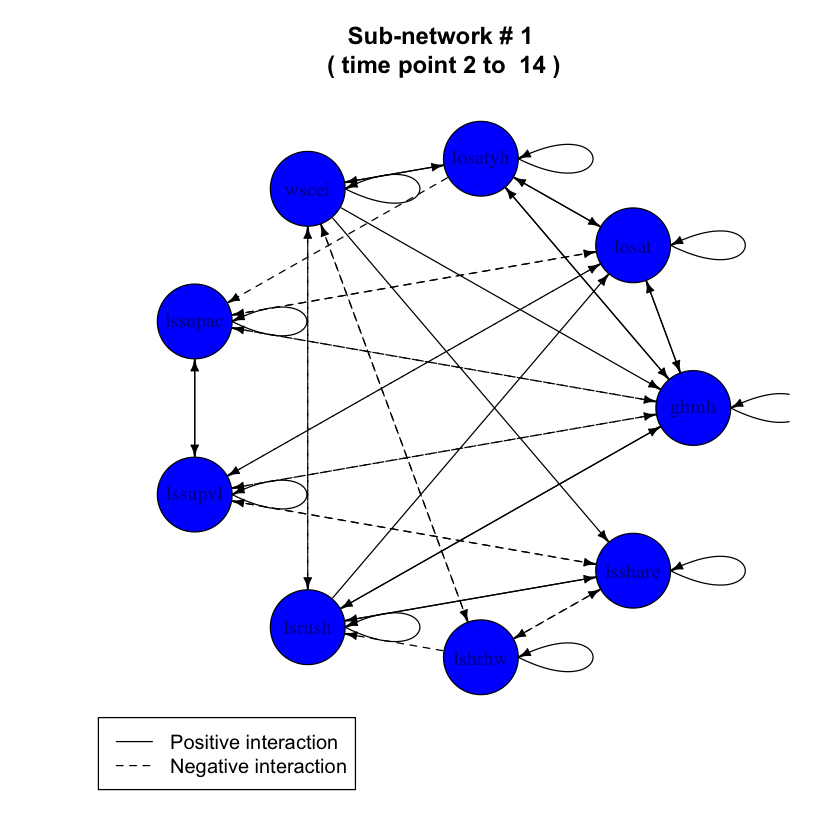

In [13]:
# We can visualize the network
source("src/traceNetwork.R")
source("src/PlotBubbleGraph.R")

# layout = geneLines, random, circle, kamada.kawai, 
#          reingold.tilford, lgl, graphopt,
#          mds, fruchterman.reingold 
traceNetwork(results, 0.95, layout = 'circle') 

Warning message in layout_as_tree(structure(list(9, TRUE, c(0, 1, 2, 3, 4, 5, 6, :
“At structural_properties.c:3338 :graph contains a cycle, partial result is returned”

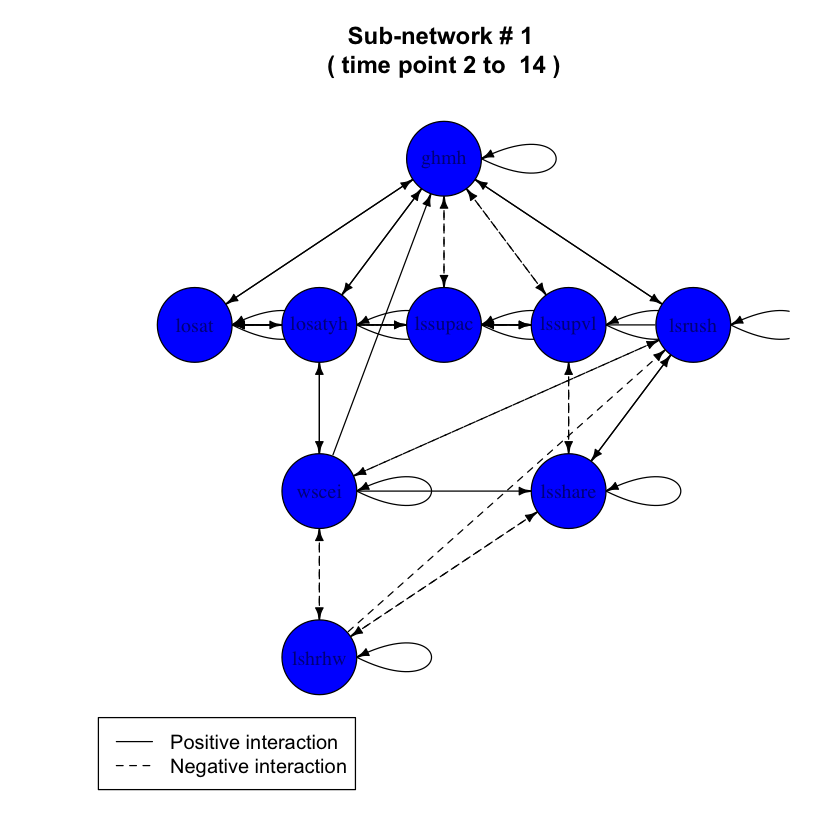

In [15]:
# layout = geneLines, random, circle, kamada.kawai, 
#          reingold.tilford, lgl, graphopt,
#          mds, fruchterman.reingold 
traceNetwork(results, 0.95, layout = 'reingold.tilford') 

The Reingold-Tilford graph reveals the mental health score `ghmh` occupies the sole central position in this causal network, under which every other node can be laid in a hierarchy of layers. At the bottom of the network, the relationship variables (based on housework `lsshare`, `lshrhw`) have no direct association with mental health, but every other variable does. However both housework scores indirectly affect mental health via personal control `lsrush` (as does weekly income `wscei`).  

#### Experiment 1 replication
***
Here we replicate Experiment 1 with a new (independent) sample. Time taken was 6.2 days.

In [4]:
results <- read.delim('results/ARTIVAnet test stationary sample2/ARTIVA_FinalNetwork.txt')
cat('The result table is an', dim(results)[1], 'row by', dim(results)[2], 'column table')
results

The result table is an 81 row by 7 column table

Parent,Target,CPstart,CPend,PostProb,CoeffMean,edgesThreshold
ghmh,ghmh,2,14,1.0000,0.55333,0.5
losat,ghmh,2,14,1.0000,0.04077,0.5
losatyh,ghmh,2,14,1.0000,0.08101,0.5
wscei,ghmh,2,14,0.9620,0.02293,0.5
lssupac,ghmh,2,14,1.0000,-0.04094,0.5
lssupvl,ghmh,2,14,1.0000,-0.08220,0.5
lsrush,ghmh,2,14,1.0000,0.05421,0.5
lshrhw,ghmh,2,14,0.1037,0.00000,0.5
lsshare,ghmh,2,14,0.0929,0.00000,0.5
ghmh,losat,2,14,1.0000,0.06279,0.5


Warning message in layout_as_tree(structure(list(9, TRUE, c(0, 1, 2, 3, 4, 5, 6, :
“At structural_properties.c:3338 :graph contains a cycle, partial result is returned”

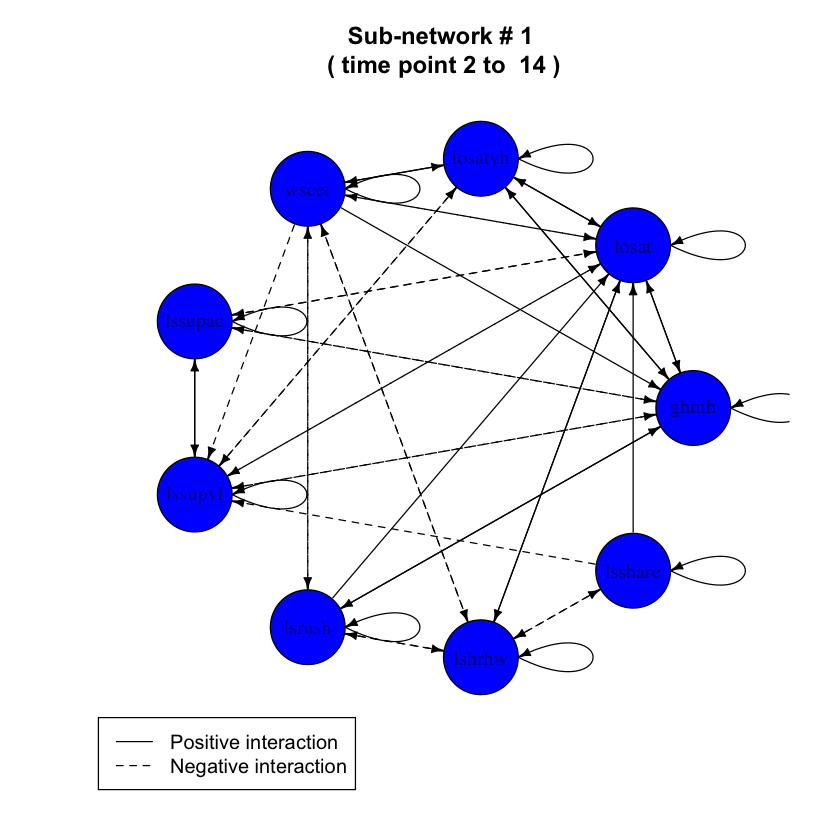

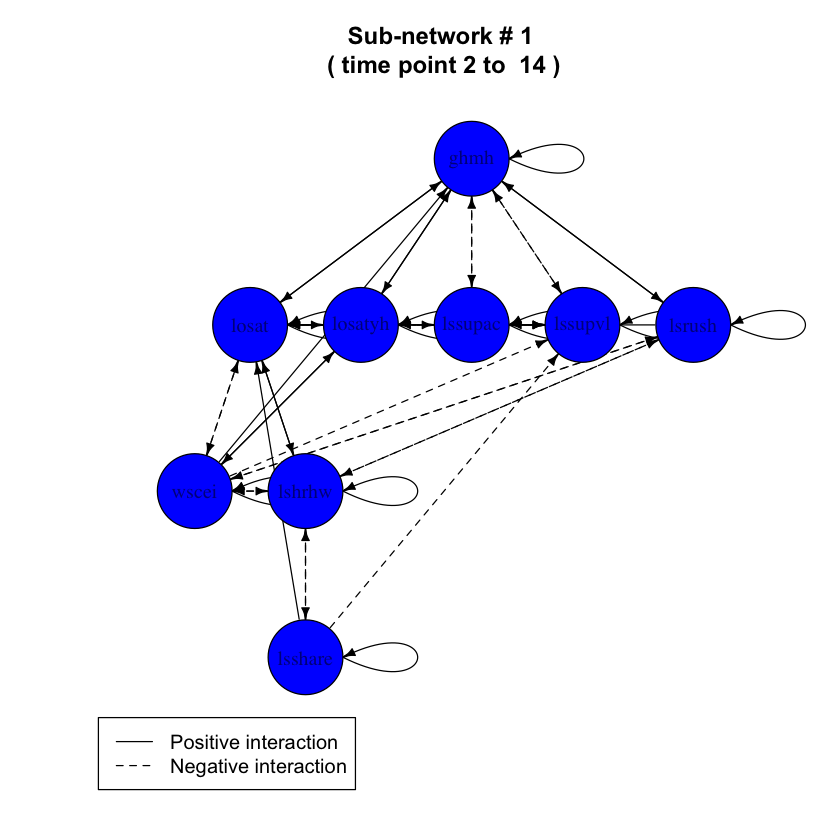

In [6]:
# We can visualize the network
source("src/traceNetwork.R")
source("src/PlotBubbleGraph.R")
traceNetwork(results, 0.95, layout = 'circle')
traceNetwork(results, 0.95, layout = 'reingold.tilford')

In comparison to the original sample, there are some differences apparent in the centrality/betweenness of `losat` and `lssupvl`. In the original sample, `ghmh` was clearly the most central variable, receiving the majority of inputs from the other variables. However here `losat` and `lssupvl` have the same number or more inputs than `ghmh`.  

However the Reingold-Tilford layout appears to show that `ghmh` occupies the same root position as before, shown here at the top of the graph. In this respect at least, we may have replicated the graph structure with respect to mental health.

## Experiment 2
***
One assumption of Experiment 1 is the network around mental health is stable across the 14 years of HILDA among our sample. This obviously may not be true for an individual, especially if some personal event has occurred which challenges their life or mental health. A unique feature of ARTIVA is that it can estimate networks which change over time (time-varying networks) by identifying *changepoints* and therefore the different subnetworks on either side of the changepoint. The HILDA dataset offers a unique opportunity to exploit this since it contains self-reported details of ' major life-events' for each respondant in each year. In the present experiment, we identify respondents in HILDA who report a single major life event in the 14 years of the survey, and test whether ARTIVA can detect a changepoint around the time of that life event.
  
### Methods
***
Experiment 2 will gather the individuals who report a single negative life event in the 14 years of the survey and test for changepoints in each individual.  
  
The variables included in the analysis were:

> 'losat' How satisfied are you with your life  
> 'losatyh' Your health  
> 'losateo' Your employment opportunities  
> 'losatfs' Your financial situation  
> 'losatft' The amount of free time you have  
> 'losathl' The home in which you live  
> 'losatlc' Feeling part of your local community  
> 'losatnl' The neighbourhood in which you live  
> 'losatsf' How safe you feel  
> 'lssupnh' I often need help from others  
> 'lssupac' I don't have anyone I can confide in  
> 'lssuplt' I have no one to lean on  
> 'lssupvl' I often feel very lonely  
> 'ghmh' mental health  
  
This includes all the life satisfaction variables, as well as social support variables, but not the financial, personal control or relationship variables in Experiment 1 (to be done)

In [ ]:
#### Get the sample of respondents with life events #####
lefnw.df <- JoinFrames(hildadata,'lefnw') # finances worse
lefnw.df[which(lefnw.df < 2, arr.ind=TRUE)] <- NA
lefnw.df[is.na(lefnw.df)] <- 0
lefnw.df[which(lefnw.df == 2, arr.ind=TRUE)] <- 1
colSums(lefnw.df)

ledsc.df <- JoinFrames(hildadata,'ledsc') # death of spouse/child
ledsc.df[which(ledsc.df < 2, arr.ind=TRUE)] <- NA
ledsc.df[is.na(ledsc.df)] <- 0
ledsc.df[which(ledsc.df == 2, arr.ind=TRUE)] <- 1
colSums(ledsc.df)

leins.df <- JoinFrames(hildadata,'leins') # injury to self
leins.df[which(leins.df < 2, arr.ind=TRUE)] <- NA
leins.df[is.na(leins.df)] <- 0
leins.df[which(leins.df == 2, arr.ind=TRUE)] <- 1
colSums(leins.df)

# Collate the events
collated.df <- lefnw.df + leins.df + ledsc.df  # Add all the bad events together
collated.df[collated.df > 0] <- 1 # recode the events to single
colSums(collated.df)
collated.df$sums <- rowSums(collated.df) # Count the events for each person
collated.df <- rownames_to_column(collated.df, 'xwaveid')
sample.df <- filter(collated.df, sums == 1) # Find people with just one bad year

#### Create the variable dataframe ####
predictors <- c('losat',    # How satisfied are you with your life
                'losatyh',  # Your health
                'losateo',  # Your employment opportunities
                'losatfs',  # Your financial situation
                'losatft',  # The amount of free time you have
                'losathl',  # The home in which you live
                'losatlc',  # Feeling part of your local community
                'losatnl',  # The neighbourhood in which you live
                'losatsf',  # How safe you feel
                'lssupnh',  # I often need help from others
                'lssupac',  # I don't have anyone I can confide in
                'lssuplt',  # I have no one to lean on
                'lssupvl',  # I often feel very lonely
                'ghmh'       # mental health
)

df.long <- GetVarsLong(hildadata, predictors, scale = TRUE)
respondants <- unique(df.long$xwaveid)

start_time <- Sys.time()
for (w in letters[3:12]) {
  
  sample.id <- sample.df$xwaveid[sample.df[w] > 0]
  df.sample <- filter(df.long, xwaveid %in% sample.id)
  selected <- unique(df.sample$xwaveid)
  print(paste0('****New wave ', w, ' with ', length(selected), ' people****'))
  
  #### Test sample in ARTIVA ####
  targets <- predictors
  parents <- predictors
  CPresults <- as.tibble()
  
  for (i in seq(length(selected))) {
    
    df.subject <- filter(df.sample, xwaveid == selected[i])
    
    datamatrix <- df.subject %>%
      spread(waveid, value) %>%
      remove_rownames() %>%
      column_to_rownames('hildacode') %>%
      dplyr::select(-xwaveid) %>%
      as.matrix()
    
    results <- ARTIVAnet(
      targetData = datamatrix[targets, ],
      parentData = datamatrix[parents, ],
      targetNames = targets,
      parentNames = parents,
      dyn = 1, # minimum lag (0 or 1)
      segMinLength = 2,
      edgesThreshold = 0.5,
      niter = 10000,
      PSRFactor = FALSE,
      saveEstimations = TRUE,
      savePictures = TRUE
    )
    
    #### Store CP position ####
    CPpaths <- list.files(
      path = 'ARTIVAnet/Estimations',
      pattern = '^CPpositionPostDist.*.txt$',
      full.names = TRUE
    )
    
    for (path in CPpaths) {
      CPtable <- read.csv(path, sep = " ")
      idx_start <- unlist(gregexpr('_', path)) + 1
      idx_end <- unlist(gregexpr('.txt', path)) - 1
      CPtable$var <- substring(path, idx_start, idx_end)
      CPtable$xwaveid <- selected[i]
      CPtable <- rownames_to_column(CPtable, 'wave')
      CPtable$wave <- as.numeric(CPtable$wave) - 7
      CPresults <- rbind(CPresults, CPtable)
    }
    
  }
}
end_time <- Sys.time()
print(end_time - start_time)
write_csv(CPresults, 'results/CPresults.csv')

### Results
***
The analysis took X days, Y hrs, Z min to complete (to be done). The posterior probability of a change point in each wave for each individual and for each variable was calculated.

In [30]:
# Table
head(CPresults)
cat('The total number of respondents was n =', length(unique(CPresults$xwaveid)))

wave,V1,var,xwaveid
-6,0.0000,ghmh,0100353
-5,0.0000,ghmh,0100353
-4,0.0000,ghmh,0100353
-3,0.2143,ghmh,0100353
-2,0.1156,ghmh,0100353
-1,0.1617,ghmh,0100353


The total number of respondents was n = 39

In [25]:
# Overall results
CPresults %>%
  filter(V1 > 0) %>%
  group_by(wave) %>%
  summarise(M = mean(V1),
            sem = sd(V1)/sqrt(n()),
            n = n()
            )

wave,M,sem,n
-3,0.08740055,0.004163846,544
-2,0.06035352,0.002568546,540
-1,0.06904889,0.003453472,540
0,0.06818866,0.003426669,538
1,0.06783892,0.003453376,537
2,0.07023550,0.003579222,538
3,0.06209982,0.003100304,543
4,0.06591134,0.003185194,538
5,0.06035807,0.002738757,539
6,0.07877661,0.003701655,543


There is clearly no peak in the average posterior probability of a changepoint near the time of negative life event (wave 0). The *n* in the table above represents the number of datapoints contributing to each mean score. It is a product of the number of variables (e.g., 14) and number of respondents in that wave (e.g., 39).  
  
We can group the results by each variable to see if a peak appears near the life event (wave 0) for any specific variables.

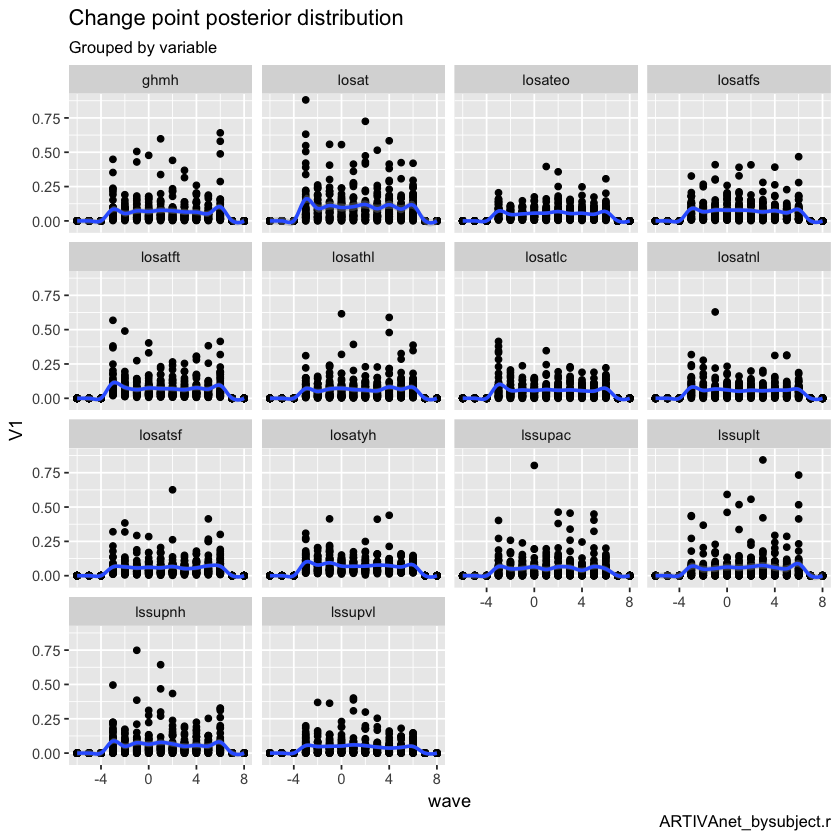

In [34]:
# Figure 
CPresults %>%
  ggplot(aes(x = wave, y = V1)) +
    geom_point() +
    geom_smooth(method = 'loess', span = 0.25) +
    facet_wrap(~var) +
    labs(title = 'Change point posterior distribution',
         subtitle = 'Grouped by variable',
         caption = 'ARTIVAnet_bysubject.r')

There is no specific variable with peaks at or near the time of the life event (wave 0). 
  
We can also filter on the maximum posterior probability of a change point in each variable (and in each individual)

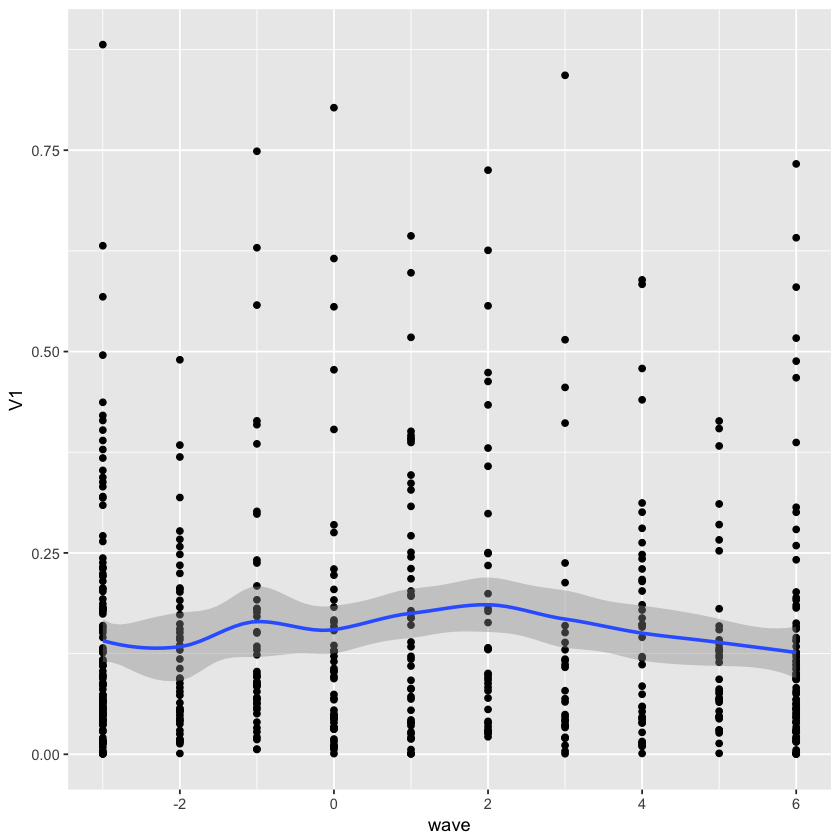

In [47]:
CPresults %>%
  filter(V1 > 0) %>%
  group_by(xwaveid, var) %>%
  filter(V1 == max(V1)) %>%
  ggplot(aes(x = wave, y = V1)) + 
    geom_point() + 
    geom_smooth(method = 'loess', span = 0.45)

Here there looks like there is a slight (very slight!) peak in the second wave after the negative life event. To be continued...